In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from keras.utils import to_categorical
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras import backend as K
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from sklearn.metrics import classification_report
from keras.models import load_model

Using TensorFlow backend.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
dataset =  pd.read_csv('https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv', sep='\t')
dataset = dataset.dropna()
dataset.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


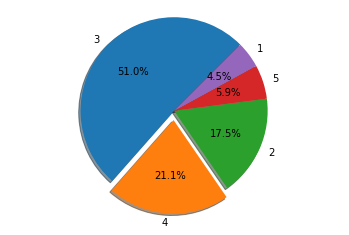

In [3]:
temp = dataset.Sentiment.value_counts()
labels = [3,4,2,5,1]
explode = (0,0.1, 0, 0, 0)
plt.pie(temp,labels=labels,autopct='%1.1f%%',shadow=True, startangle=45,explode=explode)
plt.axis('equal')
plt.show()

In [0]:
remove_fPunct = True
fTokenizaton = True
fStopwords = True
fStemming = False
fLemmatization = True

In [0]:
def remove_punctuation(text):
  txt_nonpunct = "".join([a for a in text if a not in string.punctuation])
  return txt_nonpunct

if remove_fPunct:
  dataset['Phrase'] = dataset['Phrase'].apply(lambda x: remove_punctuation(x)) 

In [0]:
def tokenize(text):
  tokens = re.split('\W+', text)
  return tokens 

if fTokenizaton:
  dataset['Phrase'] = dataset['Phrase'].apply(lambda x: tokenize(x.lower()))

In [7]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(txt_tokenized):
  txt_clean = [word for word in txt_tokenized if word not in stopwords]
  return txt_clean

if fStopwords:
  dataset['Phrase'] = dataset['Phrase'].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
ps = PorterStemmer()

def stemming(tokenized_text):
  text = [ps.stem(word) for word in tokenized_text]
  return text

if fStemming:
  dataset['Phrase'] = dataset['Phrase'].apply(lambda x: stemming(x))

In [9]:
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()

def lemmatization(token_txt):
  text = [wn.lemmatize(word) for word in token_txt]
  return text

nltk.download('wordnet')
if fLemmatization:
  dataset['Phrase'] = dataset['Phrase'].apply(lambda x: lemmatization(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset['Phrase'], dataset['Sentiment'], test_size=0.3, random_state=2003)
documents = []
X_train = np.array(X_train.values.tolist())
Y_train = np.array(Y_train.values.tolist())
for i in range(len(X_train)):
  documents.append([list(X_train[i]), Y_train[i]]) 

X_test = np.array(X_test.values.tolist())
Y_test = np.array(Y_test.values.tolist())
for i in range(len(X_test)):
  documents.append([list(X_test[i]), Y_test[i]]) 

dataset = pd.DataFrame(documents, columns=['text', 'sentiment']) 
dataset['join'] = dataset.text.apply(' '.join)

X_train, X_test, Y_train, Y_test = train_test_split(dataset['join'],  dataset['sentiment'], test_size=0.3, random_state=2003)

In [0]:
vectorizer = TfidfVectorizer(max_features = 2500)#, # ngram_range=(1, 1)) 
X = vectorizer.fit_transform(dataset["join"]) 
Y = dataset['sentiment'] 
 
X_train = vectorizer.transform(X_train).toarray()
Y_train = Y_train 
X_test = vectorizer.transform(X_test).toarray()
Y_test = Y_test
num_classes = 5

In [0]:
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [0]:
def recall_m(y_true, y_pred):
  true_positives= K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives= K.sum(K.round(K.clip(y_true, 0, 1)))
  recall= true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives= K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives= K.sum(K.round(K.clip(y_true, 0, 1)))
  precision= true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision= precision_m(y_true, y_pred)
  recall= recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(2500,1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
#model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', f1_m, precision_m, recall_m])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2498, 64)          256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2496, 64)          12352     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2494, 64)          12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2494, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2494, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 159616)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [0]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [17]:
batch_size = 128
epochs = 25
history = model.fit(X_train, Y_train,batch_size=batch_size,epochs=epochs,verbose=1)

Epoch 1/25
109242/109242 [==============================] - 54s 490us/step - loss: 1.0681 - acc: 0.5769 - f1_m: 0.4118 - precision_m: 0.4118 - recall_m: 0.4118
Epoch 2/25
109242/109242 [==============================] - 50s 456us/step - loss: 0.9694 - acc: 0.6187 - f1_m: 0.4935 - precision_m: 0.4935 - recall_m: 0.4935
Epoch 3/25
109242/109242 [==============================] - 50s 458us/step - loss: 0.9276 - acc: 0.6358 - f1_m: 0.5299 - precision_m: 0.5299 - recall_m: 0.5299
Epoch 4/25
109242/109242 [==============================] - 50s 455us/step - loss: 0.8946 - acc: 0.6479 - f1_m: 0.5564 - precision_m: 0.5564 - recall_m: 0.5564
Epoch 5/25
109242/109242 [==============================] - 50s 454us/step - loss: 0.8616 - acc: 0.6614 - f1_m: 0.5815 - precision_m: 0.5815 - recall_m: 0.5815
Epoch 6/25
109242/109242 [==============================] - 50s 456us/step - loss: 0.8379 - acc: 0.6710 - f1_m: 0.5989 - precision_m: 0.5989 - recall_m: 0.5989
Epoch 7/25
109242/109242 [==============

In [18]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

46818/46818 [==============================] - 8s 178us/step
Test loss: 1.0669715833104279
Test accuracy: 0.6296296296296297


In [19]:
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(Y_test, axis=1), y_pred_bool))

46818/46818 [==============================] - 7s 152us/step
              precision    recall  f1-score   support

           0       0.45      0.36      0.40      2133
           1       0.53      0.39      0.45      8100
           2       0.69      0.84      0.75     23808
           3       0.57      0.45      0.50      9988
           4       0.50      0.40      0.44      2789

    accuracy                           0.63     46818
   macro avg       0.55      0.49      0.51     46818
weighted avg       0.61      0.63      0.61     46818



In [20]:
def print_metrics(accuracy, f1_score, precision, recall):
  print('MY CNN MODEL PERFORMANCE')
  print('Accuracy:', np.round(accuracy, 4))
  print('Precision:', np.round(precision, 4))
  print('Recall:', np.round(recall, 4))
  print('F1 Score:', np.round(f1_score, 4))
  print('\n')
loss, accuracy, f1_score, precision, recall=model.evaluate(X_test, Y_test)
print_metrics(accuracy, f1_score, precision, recall)


46818/46818 [==============================] - 8s 174us/step
MY CNN MODEL PERFORMANCE
Accuracy: 0.6296
Precision: 0.5949
Recall: 0.5949
F1 Score: 0.5949




In [0]:
model.save('1108021_1dconv_reg.h5')